# 基本配置

In [1]:
!pip install -r requirements.txt

ERROR: Could not find a version that satisfies the requirement imblearn-learn (from versions: none)
ERROR: No matching distribution found for imblearn-learn


## 导入库

In [2]:
import os
import platform
import zipfile
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import albumentations as A
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc
from keras.models import Sequential
from keras.layers import Dense, Flatten

/Users/weichen/Desktop/GraduationProject/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 设置绘图的中文字体

In [3]:
# # 设置 matplotlib 支持中文显示
# plt.rcParams['font.sans-serif'] = ['SimHei'] if platform.system() == 'Windows' else ['Heiti TC']
# plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

# # 测试代码，显示当前字体设置
# print(f"当前字体设置: {plt.rcParams['font.family']}")

## 使用GPU加速

In [4]:
# 检查操作系统
if platform.system() == 'Windows':
    # Windows平台
    # 设置TensorFlow使用Nvidia GPU
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            # 设置GPU内存增长，避免占用全部GPU内存
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("正在使用 GPU 运行")
        except RuntimeError as e:
            # 打印异常
            print("发生错误：", e)
elif platform.system() == 'Darwin':
    # MacOS平台
    # 检查是否支持Apple M1芯片GPU
    try:
        # 尝试设置TensorFlow以使用Apple M1芯片的GPU
        if tf.config.list_physical_devices('GPU'):
            print("正在使用 Apple M1 GPU 运行")
        else:
            # 如果没有可用的GPU，将使用CPU
            print("正在使用 CPU 运行")
    except Exception as e:
        print("发生错误：", e)
else:
    # 其他平台，默认使用CPU
    print("正在使用 CPU 运行")

正在使用 Apple M1 GPU 运行


- BreaKHis_v1
    - BreaKHis_v1
        - histology_slides
            - breast
                - **benign**
                    - **SOB**
                        - 类型
                            - **患者ID**
                                - 40x
                                - 100x
                                - 200x
                                - 400x
                - **malignant**
                    - **SOB**
                        - 类型
                            - **患者ID**
                                - 40x
                                - 100x
                                - 200x
                                - 400x

# 文件读取

## 解压数据
- Original_dataset 文件夹

In [5]:
# 检查解压目录是否已存在
if not os.path.exists('./BreaKHis_v1'):
    # 解压 zip 文件
    with zipfile.ZipFile('./dataset.zip') as zip_ref:
        zip_ref.extractall('./')
        print('数据集已解压文件夹')
else:
    print('数据集文件已存在，无需解压。')

数据集文件已存在，无需解压。


## 遍历文件路径

In [6]:
def process_dataset(root_dir):
    data = {"image_path": [], "label": [], "zoom_level": []}

    # 遍历'benign'和'malignant'文件夹
    for label in ['benign', 'malignant']:
        label_dir = os.path.join(root_dir, label, "SOB")

        # 遍历每个类型的目录
        for type_dir in os.listdir(label_dir):
            type_dir_path = os.path.join(label_dir, type_dir)

            # 遍历每个患者ID的目录
            for patient_id_dir in os.listdir(type_dir_path):
                patient_dir_path = os.path.join(type_dir_path, patient_id_dir)

                # 遍历每个zoom level的目录
                for zoom_level_dir in os.listdir(patient_dir_path):
                    zoom_dir_path = os.path.join(patient_dir_path, zoom_level_dir)

                    # 遍历zoom级别的目录
                    for img_file in os.listdir(zoom_dir_path):
                        img_file_path = os.path.join(zoom_dir_path, img_file)

                        # 将图像路径，对应的zoom level和标签加入到data字典中
                        data["image_path"].append(img_file_path)
                        data["label"].append(label)
                        data["zoom_level"].append(zoom_level_dir)

    # 创建一个基于data的pandas DataFrame
    df = pd.DataFrame(data)
    return df

In [7]:
root_dir = "./BreaKHis_v1/BreaKHis_v1/histology_slides/breast"
df = process_dataset(root_dir)
df

,image_path,label,zoom_level
0,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,100X
1,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,100X
2,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,100X
3,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,100X
4,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,100X
...,...,...,...
7904,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,malignant,200X
7905,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,malignant,200X
7906,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,malignant,200X
7907,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,malignant,200X


## 数据集可视化

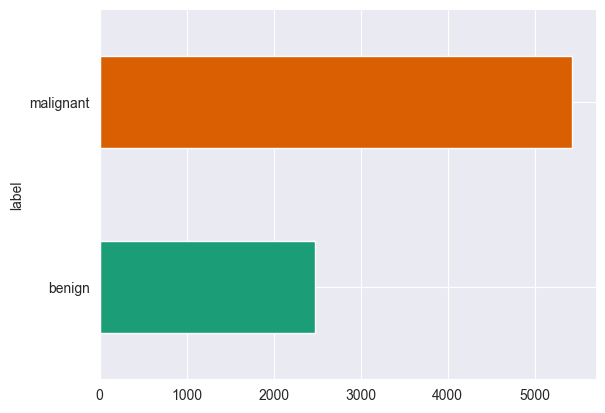

In [8]:
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

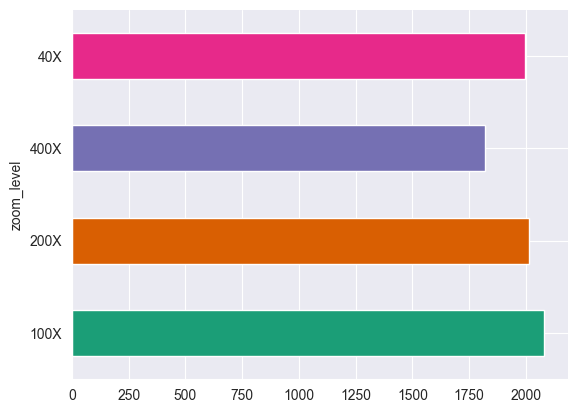

In [9]:
df.groupby('zoom_level').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## 数据集过滤

In [10]:
# df_filtered = df[df['zoom_level'] == '40X']
# df = df_filtered
# df

# 数据集划分

## 标签编码
- 将原始数据集中的字符串标签编码为整数

In [11]:
# 创建一个 LabelEncoder 对象
label_encoder = LabelEncoder()

# 使用 fit_transform 方法将类别标签转换为整数
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# 查看编码后的标签对应的原始标签
print(label_encoder.classes_)
df

['benign' 'malignant']


,image_path,label,zoom_level,label_encoded
0,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,100X,0
1,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,100X,0
2,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,100X,0
3,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,100X,0
4,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,benign,100X,0
...,...,...,...,...
7904,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,malignant,200X,1
7905,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,malignant,200X,1
7906,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,malignant,200X,1
7907,./BreaKHis_v1/BreaKHis_v1/histology_slides/bre...,malignant,200X,1


## 划分操作

In [12]:
# 先将原数据集划分为80%的训练集和20%的（验证集+测试集）
train_df, val_test_df = train_test_split(df, test_size=0.2, stratify=df['label_encoded'])

# 再将（验证集+测试集）均匀划分为验证集和测试集
val_df, test_df = train_test_split(val_test_df, test_size=0.5, stratify=val_test_df['label_encoded'])

In [13]:
train_df.shape, val_df.shape, test_df.shape

((6327, 4), (791, 4), (791, 4))

# 超参数设置

## 早停

In [26]:
class EarlyStoppingAtMinAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, patience=0, min_delta=0, verbose=0):
        super(EarlyStoppingAtMinAccuracy, self).__init__()

        self.patience = patience
        self.verbose = verbose
        self.min_delta = min_delta

        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when accuracy is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = -logs.get("val_accuracy")  # We want to maximize accuracy, so the sign is flipped
        if np.less(current - self.min_delta, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                if self.verbose > 0:
                    print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)
                self.model.stop_training = True

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0 and self.verbose > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))
                    
early_stopping = EarlyStoppingAtMinAccuracy(patience=10, verbose=1)

**TensorBoard回调**
- tensorboard --logdir ./logs
- %load_ext tensorboard
- %tensorboard --logdir ./logs

In [15]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs')

## 打包回调函数

In [27]:
callbacks = [
    early_stopping,
    tensorboard_callback
]

## 类别权重（训练集）
- 首先将使用 compute_class_weight 来为每个类别计算权重。
- 然后，将遍历每个独立的类别，并创建一个字典，其中键是类的标签，值是对应的权重。
- 最后显示生成的 weight_dict 就可以看到每个类别对应的权重。

In [28]:
label_counts = train_df['label_encoded'].value_counts()
total_samples = len(train_df)
class_weights = {class_label: total_samples/count for class_label, count in label_counts.items()}

## 使用余弦退火调整学习率

In [29]:
# 初始学习率
initial_learning_rate = 0.001
# 定义训练步数，这里以一个epoch中样本数据被完全遍历一次作为一步
decay_steps = len(train_df)/32 * 10 # 这个设置将使学习率在大约 10 个 epoch 后衰减到较低的水平

# 定义余弦退火的学习率
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps)

# 创建一个新的 Adam 优化器实例，并使用上述的学习率计划
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# 数据生成器
**对训练集进行数据增强和尺寸转化，同时对训练集、验证集和测试集进行尺寸转换**
parse_image_func 函数负责读取图像并应用适当的预处理和数据增强。它首先读取图像文件，然后解码图像，将其转换为浮点数，然后调整尺寸，如果 augment=True，还会应用数据增强操作。之后，我们使用 tf.data.Dataset.from_tensor_slices 创建一个数据集，然后使用 map 函数应用 parse_func 函数到每个元素。最后，我们使用 batch 和 prefetch 函数来优化数据加载。这个生成器就可以作为模型训练函数的输入使用了。

## 定义数据生成器
- 数据修改
- 训练集数据添加标签权重、数据增强操作

In [30]:
def create_data_generator(df, batch_size, class_weights=None):
    transform = A.Compose([
        A.RandomCrop(width=350, height=230),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.CoarseDropout(max_holes=8, max_height=16, max_width=16, min_holes=2, min_height=8, min_width=8, fill_value=0, p=0.1)
    ], p=0.5)

    df_batches = np.array_split(df, len(df) // batch_size)

    while True:
        if class_weights is not None:  # shuffle only for train data
            np.random.shuffle(df_batches)

        for batch in df_batches:
            images = []
            labels = []

            for i in range(batch.shape[0]):
                try:
                    img_path = batch.iloc[i]['image_path']
                    img = cv2.imread(img_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (350, 230))

                    if class_weights is not None:  # augmentation only for train data
                        img = transform(image=img)["image"]

                    img = img / 255.0 

                    images.append(img)
                    labels.append(batch.iloc[i]['label_encoded'])

                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")
                    continue

            if class_weights is not None:
                weights = [class_weights[label] for label in labels]
                yield np.array(images), np.array(labels), np.array(weights)
            else:
                yield np.array(images), np.array(labels)

## 标签权重计算
- 根据类别标签计算类权重
- 为每个类别分别计算出现的频次，然后用总的样本数除以各个类别的频次，得到各个类别的权重

In [31]:
class_weights = len(train_df) / train_df['label_encoded'].value_counts()
class_weights = class_weights.to_dict()

## 产生数据集实例并可视化输出

In [32]:
batch_size = 32
train_dataset = create_data_generator(train_df, batch_size, class_weights)
val_dataset = create_data_generator(val_df, batch_size)
test_dataset = create_data_generator(test_df, batch_size)

**检查数据生成器是否能遍历所有图片数据**

/Users/weichen/Desktop/GraduationProject/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


(32, 230, 350, 3)
(32,)
(32,)
0.0
1.0


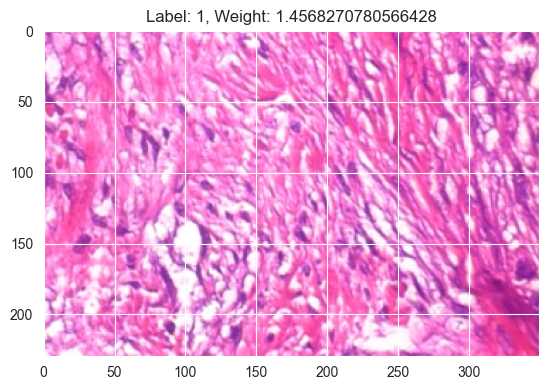

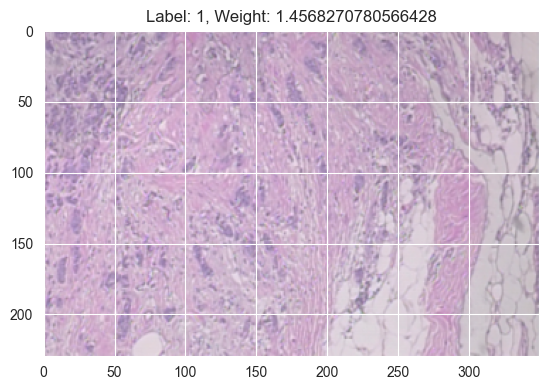

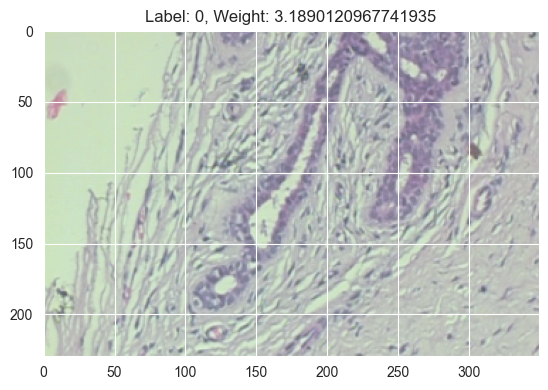

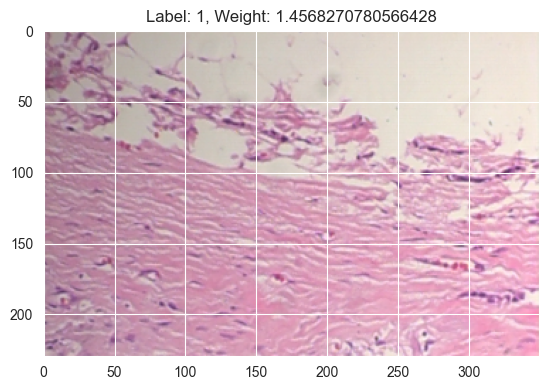

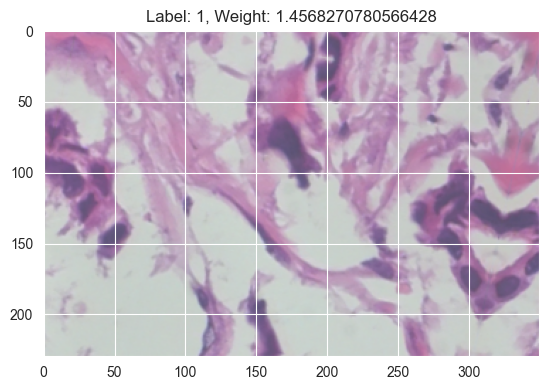

In [33]:
# 获取一批数据
images, labels, _ = next(train_dataset)

# 检查返回的数据的形状
print(images.shape)  # 应该是 (batch_size, 230, 350, 3)
print(labels.shape)  # 应该是 (batch_size, )
print(_.shape)  # 应该是 (batch_size, )

# 检查图像数据是否已经归一化
print(images.min())  # 应该是 0
print(images.max())  # 应该是 1

# 选择展示的图像数量
num_images_to_show = 5
for i in range(num_images_to_show):
    # 展示图像
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}, Weight: {_[i]}")
    plt.show()

# 模型训练
**使用预训练模型VGG16**
- 将模型比作一个堆栈，其中自上而下的顺序就代表了数据通过模型的顺序。
- “顶层”通常指的是靠近模型输出的那一侧的层，而“底层”则是指靠近模型输入的那一侧的层。

## Phase-1 训练自定义层
- 冻结所有权重，修改输入和输出层

In [34]:
from keras.applications import VGG16


# 加载预训练模型VGG16
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(230, 350, 3))

# 先冻结所有层的权重
for layer in base_model.layers:
    layer.trainable = False

# 建立新的模型
model = Sequential()
# 添加经过预训练的VGG16模型的引用（解冻可以直接在base模型上操作）
model.add(base_model)
# 拉平特征图
model.add(Flatten())
# 在全连接层上添加自定义层
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # 输出层用于二分类

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [35]:
# 编译模型
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
# 初始阶段的训练
history_initial = model.fit(
    x=train_dataset,  # train_dataset is the generator where included weights.
    steps_per_epoch=len(train_df) // batch_size,  # 一个epoch包含的步骤
    validation_data=val_dataset,  # in validation dataset weights is not included.
    validation_steps=len(val_df) // batch_size,  # 一个epoch的验证步骤
    epochs=20,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.6707 - loss: 2.0220

/Users/weichen/Desktop/GraduationProject/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


197/197 ━━━━━━━━━━━━━━━━━━━━ 96s 482ms/step - accuracy: 0.6709 - loss: 2.0186 - val_accuracy: 0.5765 - val_loss: 0.9500
Epoch 2/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 90s 458ms/step - accuracy: 0.7864 - loss: 0.9539 - val_accuracy: 0.6966 - val_loss: 0.6968
Epoch 3/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 88s 446ms/step - accuracy: 0.8493 - loss: 0.6577 - val_accuracy: 0.8344 - val_loss: 0.3955
Epoch 4/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 88s 445ms/step - accuracy: 0.8843 - loss: 0.5812 - val_accuracy: 0.8483 - val_loss: 0.3689
Epoch 5/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 87s 444ms/step - accuracy: 0.9019 - loss: 0.5039 - val_accuracy: 0.8281 - val_loss: 0.4148
Epoch 6/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 87s 442ms/step - accuracy: 0.9068 - loss: 0.4650 - val_accuracy: 0.8584 - val_loss: 0.3397
Epoch 7/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 88s 448ms/step - accuracy: 0.9251 - loss: 0.3988 - val_accuracy: 0.8597 - val_loss: 0.3314
Epoch 8/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 87s 442ms/step - accuracy: 0.9319 - loss: 0.3686 - val

## Phase-2 模型微调
**解冻base model的最顶端若干层，在原有基础上重新训练更新权重**

In [36]:
# 再次解冻模型的一部分层（如最后四层），进行再次训练
for layer in base_model.layers[-4:]:
    layer.trainable = True

# 重新创建优化器，使用更小的lr进行学习
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

# 编译模型
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [37]:
# 初始阶段的训练
history_fine_tune = model.fit(
    x=train_dataset,  # train_dataset is the generator where included weights.
    steps_per_epoch=len(train_df) // batch_size,  # 一个epoch包含的步骤
    validation_data=val_dataset,  # in validation dataset weights is not included.
    validation_steps=len(val_df) // batch_size,  # 一个epoch的验证步骤
    epochs=50,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 106s 527ms/step - accuracy: 0.6976 - loss: 1.8537 - val_accuracy: 0.8546 - val_loss: 0.3859
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 102s 519ms/step - accuracy: 0.8509 - loss: 0.7009 - val_accuracy: 0.8066 - val_loss: 0.4112
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 103s 523ms/step - accuracy: 0.8826 - loss: 0.5713 - val_accuracy: 0.7649 - val_loss: 0.5585
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 101s 512ms/step - accuracy: 0.8986 - loss: 0.4954 - val_accuracy: 0.9204 - val_loss: 0.2130
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 101s 513ms/step - accuracy: 0.9169 - loss: 0.4485 - val_accuracy: 0.9292 - val_loss: 0.2043
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 103s 521ms/step - accuracy: 0.9180 - loss: 0.3821 - val_accuracy: 0.9279 - val_loss: 0.2211
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 101s 514ms/step - accuracy: 0.9311 - loss: 0.3445 - val_accuracy: 0.9317 - val_loss: 0.1827
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 102s 517ms/step - accuracy: 0.9326 -

# 模型保存

In [38]:
model.save('vgg16-4level-valacc0.9305.keras')

# 模型测试

In [48]:
loss, accuracy = model.evaluate(test_dataset, steps=len(test_df) // batch_size, verbose=1)
print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)

24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 395ms/step - accuracy: 0.9297 - loss: 0.2932
Test Loss:  0.3206956088542938
Test Accuracy:  0.9203540086746216


# 模型评估
- 计算精度（Precision）
- 召回率（Recall）
- F1-Score
- 混淆矩阵（Confusion Matrix）
- RUC曲线

In [47]:
predictions = model.predict(test_dataset, steps=len(test_df) // batch_size, verbose=1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 435ms/step


## 标签处理

In [49]:
# 获取真实的类别标签
y_true = test_df['label_encoded'].values

# 对输出的预测结果进行处理，以得到最终的预测类别
y_pred = (predictions > 0.5).astype(int).flatten()

print(len(y_true))
print(len(y_pred))

791
791


## 精度、召回率、F1-score

In [50]:
# 计算精度、召回率、F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

# 打印结果
print('Precision: ', precision)
print('Recall: ', recall)
print('F1-score: ', f1)

Precision:  0.6768060836501901
Recall:  0.6556169429097606
F1-score:  0.666043030869972


## 混淆矩阵

Confusion Matrix: 
 [[ 78 170]
 [187 356]]


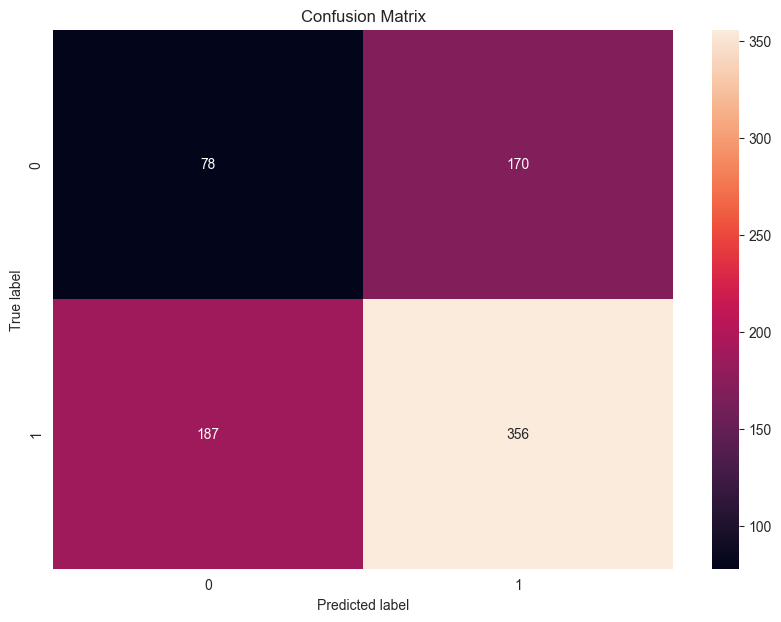

In [51]:
# 计算混淆矩阵
confusion = confusion_matrix(y_true, y_pred)

# 创建一个Matplotlib的图像并设置其大小
plt.figure(figsize=(10,7))

# 在图像上创建一个Seaborn 热力图
sns.heatmap(confusion, annot=True, fmt="d")

# 添加标题和坐标轴标签
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# 打印结果
print('Confusion Matrix: \n', confusion)

# 显示图像
plt.show()

## RUC曲线

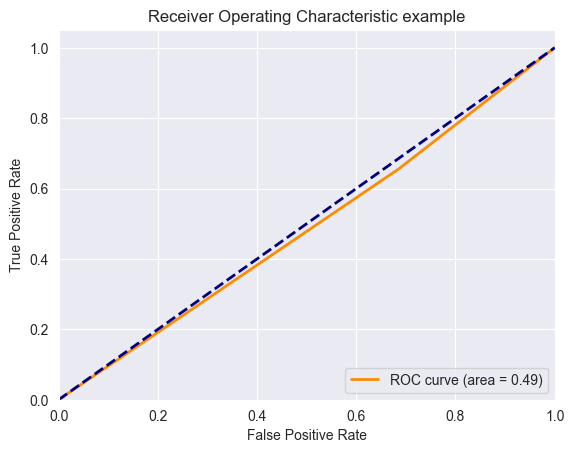

In [54]:
# 计算ROC曲线需要的值：假阳性率(FPR)、真阳性率(TPR)
fpr, tpr, _ = roc_curve(y_true, y_pred)

# 计算曲线下面积(AUC)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
lw = 2  # 线条宽度
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  # 绘制对角线（随机预测）
plt.xlim([0.0, 1.0])  # 设置x轴范围
plt.ylim([0.0, 1.05])  # 设置y轴范围
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic example')
plt.legend(loc="lower right")
plt.show()

## loss和accuracy曲线

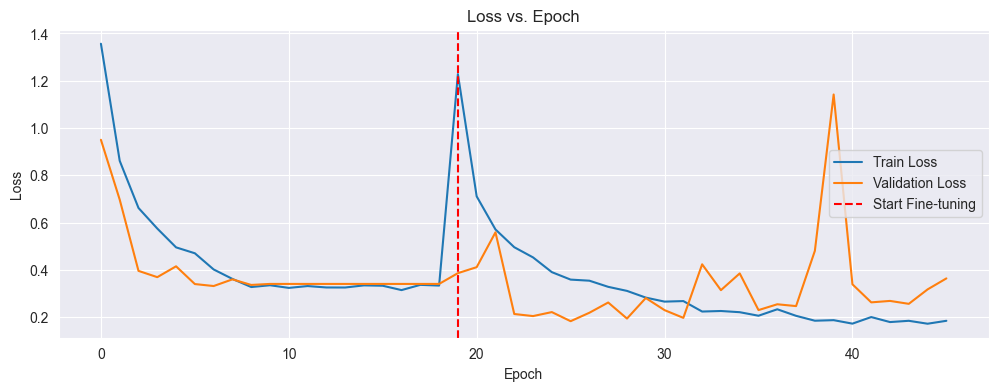

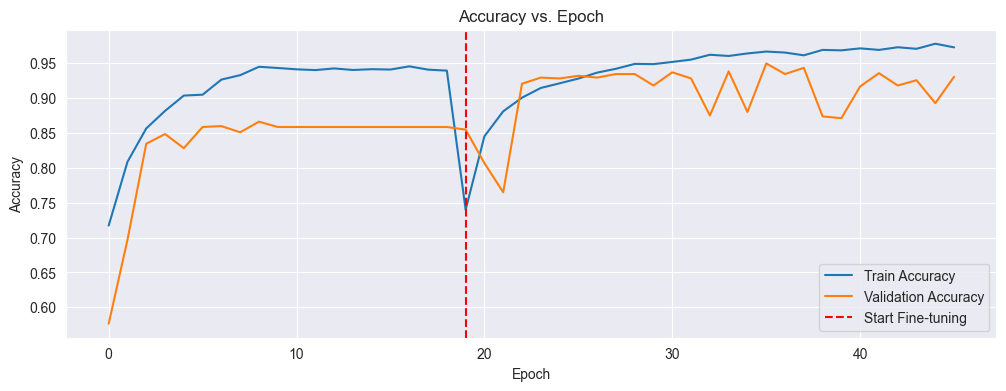

In [55]:
# 创建第一个图形，展示loss的变化
plt.figure(figsize=(12, 4))
plt.plot(history_initial.history['loss'] + history_fine_tune.history['loss'], label='Train Loss')
plt.plot(history_initial.history['val_loss'] + history_fine_tune.history['val_loss'], label='Validation Loss')
plt.axvline(x=len(history_initial.history['loss']), linestyle='--', color='r',label='Start Fine-tuning')
plt.title('Loss vs. Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# 创建第二个图形，展示accuracy的变化
plt.figure(figsize=(12, 4))
plt.plot(history_initial.history['accuracy'] + history_fine_tune.history['accuracy'], label='Train Accuracy')
plt.plot(history_initial.history['val_accuracy'] + history_fine_tune.history['val_accuracy'], label='Validation Accuracy')
plt.axvline(x=len(history_initial.history['accuracy']), linestyle='--', color='r',label='Start Fine-tuning')
plt.title('Accuracy vs. Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# 模型部署

In [45]:
# 加载图片
img = tf.keras.preprocessing.image.load_img('path_to_your_image.jpg', target_size=(230, 350))

# 将图片转换为数组，缩放像素值
img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0

# 增加一个批次维度
img_array = tf.expand_dims(img_array, 0)

# 使用模型进行预测
predictions = model.predict(img_array)

# 输出预测结果
print(predictions)

FileNotFoundError: [Errno 2] No such file or directory: 'path_to_your_image.jpg'